In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import matplotlib.pyplot as plt
import pylab
import librosa
import librosa.display
import numpy as np
import pandas as pd
import io
import tarfile
import PIL
import boto3
from fastai import *
from fastai.vision import *
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
sz = 128
bs = 128
nfolds = 4 #keep the same split as the initial dataset
fold = 0
SEED = 2019
TRAIN = '../input/grapheme-imgs-128x128/'
LABELS = '../input/bengaliai-cv19/train.csv'
arch = models.resnet34

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]
print(nunique)
df.tail()

[168, 11, 7]


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো
200839,Train_200839,127,2,0,ল্টি


In [4]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

TEST = ['/kaggle/input/bengaliai-cv19/test_image_data_0.parquet',
         '/kaggle/input/bengaliai-cv19/test_image_data_1.parquet',
         '/kaggle/input/bengaliai-cv19/test_image_data_2.parquet',
         '/kaggle/input/bengaliai-cv19/test_image_data_3.parquet']

OUT_TEST = 'test.zip'

In [5]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80) #try 60
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

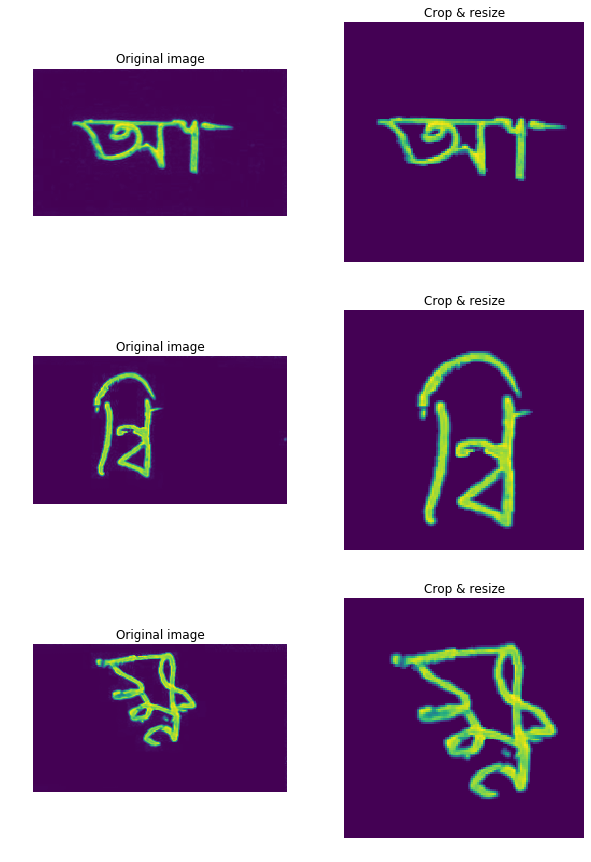

In [6]:
df = pd.read_parquet(TEST[0])
n_imgs = 3
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()


In [7]:
df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]
print(nunique)
df.tail()

[168, 11, 7]


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো
200839,Train_200839,127,2,0,ল্টি


In [8]:
stats = ([0.0692], [0.2051])
data1 = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['grapheme_root'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

#data1.show_batch()

In [9]:
stats = ([0.0692], [0.2051])
data2 = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['vowel_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

#data2.show_batch()


In [10]:
stats = ([0.0692], [0.2051])
data3 = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['consonant_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

#data3.show_batch()

In [11]:
learn1 = cnn_learner(data1,models.densenet121, pretrained=False)
learn2 = cnn_learner(data2, models.densenet121, pretrained=False)
learn3 = cnn_learner(data3, models.densenet121, pretrained=False)

In [12]:
learn1.load('/kaggle/input/densenetmodel/denseuf-1')
learn2.load('/kaggle/input/densenetmodel/denseuf-2')
learn3.load('/kaggle/input/densenetmodel/denseuf-3')

Learner(data=ImageDataBunch;

Train: LabelList (150630 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
2,0,5,0,1
Path: .;

Valid: LabelList (50210 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
5,0,5,2,5
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Co

In [13]:
file_name = []
pred = []
for fname in TEST:
    df1 = pd.read_parquet(fname)
    #the input is inverted
    data = 255 - df1.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
    for idx in tqdm(range(len(df1))):
        name = df1.iloc[idx,0]
        #normalize each image by its max val
        img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
        img = crop_resize(img)
    # to make prediction with {model}.predict converting to tensor is important
        img = np.stack((img,)*3, axis=-1)
        img = pil2tensor(img,np.float32).div_(255)
        c=int(learn3.predict(Image(img))[0])
        pred.append(c)
        file_name.append(str(name)+'_'+'consonant_diacritic')
        g=int(learn1.predict(Image(img))[0])
        pred.append(g)
        file_name.append(str(name)+'_'+'grapheme_root')
        v=int(learn2.predict(Image(img))[0])
        pred.append(v)
        file_name.append(str(name)+'_'+'vowel_diacritic')

In [14]:
row_id = pd.Series(file_name)
catag = pd.Series(pred)
frame = { 'row_id': row_id , 'target': catag} 
result = pd.DataFrame(frame)
result.to_csv('submission.csv',index=False)

In [15]:
del file_name
del pred
del row_id
del catag
del df
del frame